# Neural Networks Learning

## 1 Neural Networks

### 1.1 Visualizing the data

In [1]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Setup the parameters you will use for this exercise
input_layer_size = 400   # input layer - each image of a digit is 20x20 pixels
hidden_layer_size = 25   # hidden layer - 25 units
num_labels = 10          # output layer - 10 labels, from 1 to 10, note "0" is labelled as 10

In [3]:
# Load training data
data = scipy.io.loadmat('data/ex4data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
# X is 5,000 examples of 20x20 pixel images, each image is a handwritten number
# Each 20x20 image is stored as a 400-dimensional vector
data['X'].shape

(5000, 400)

In [5]:
# y is the numeral represented by each image# y is  
data['y'].shape

(5000, 1)

In [6]:
# Store data in numpy arrays to make things easier
X = data['X']
y = data['y']

In [7]:
m = X.shape[0] # number of examples

In [8]:
# Randomly select 100 images to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

In [9]:
def display_data(X):
    '''
    Displays 2D data stored in X in a nice grid.
    '''
    m = X.shape[0] # number of images
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    n = X.shape[1] # pixels per image
    image_side = int(math.sqrt(n))
    
    plt.figure(figsize=(8,8))
    
    for i in range(m):
        image = X[i]
        image = np.reshape(image, (image_side, image_side), order='F')
        plt.subplot(display_rows, display_cols, i+1)
        plt.imshow(image, cmap='Greys')
        plt.axis('off')
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

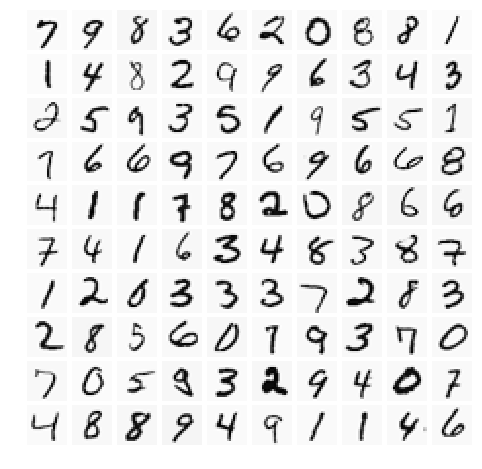

In [10]:
display_data(sel)

### 1.2 Model representation

In [11]:
# Load pre-initialized weights into variables Theta1 and Theta2
weights = scipy.io.loadmat('data/ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

In [12]:
Theta1.shape
# 20x20 pixels = 400 + 1 bias unit -> 401 input units
# Second (hidden) layer has 25 units

(25, 401)

In [13]:
Theta2.shape
# Second layer's 25 units + 1 bias unit
# Output layer has 10 units for 0-9

(10, 26)

In [14]:
# Unroll parameters 
nn_params = np.append(Theta1.flatten(order='F'), Theta2.flatten(order='F'))

### 1.3 Feedforward and cost function

In [15]:
def sigmoid(z):
    g = 1. / (1. + math.exp(-z))
    return g

sigmoid = np.vectorize(sigmoid)

In [16]:
def sigmoid_gradient(z):
    '''
    Computes the gradient of the sigmoid function evaluated at z.
    '''
    g = 1. / (1. + math.exp(-z)) * (1 - 1. / (1. + math.exp(-z)))
    return g

sigmoid_gradient = np.vectorize(sigmoid_gradient)

In [17]:
def NN_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    '''
    Computes the cost and gradient for a two layer
    neural network which performs classification.
    '''
    
    J = 0

    # Reshape nn_params back into weight matrices Theta1 and Theta2
    Theta1 = np.reshape(nn_params[:(hidden_layer_size * (input_layer_size + 1))],
                        (hidden_layer_size, (input_layer_size + 1)), order='F')

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)), order='F')

    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)    

    m = X.shape[0] # number of examples


    ## Feedforward neural network
    # Add column of ones to X for bias
    a1 = X
    a1 = np.column_stack((np.ones(m), a1))
    
    # Calculate outputs of hidden layer
    z2 = np.dot(a1, Theta1.T)
    a2 = sigmoid(z2)
    
    # Add column of ones to hidden layer output for bias
    a2 = np.column_stack((np.ones(a2.shape[0]), a2))
    
    # Calculate outputs of output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    
    ## Compute cost
    J1 = 0
    J2 = 0
    
    for i in range(m): # loop over examples
        # Logical version of y
        y_bools = np.zeros(num_labels)
        y_bools[y[i]-1] = 1 # -1 because y runs from 1-10 but num_labels runs from 0-9

        J1 += np.sum(-y_bools*np.log(a3[i,:]) - (1 - y_bools)*np.log(1 - a3[i,:]))
    J1 = J1/m
    
    J2 = np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:]**2)
    J2 = J2 * Lambda / (2*m)
    
    J = J1 + J2
    
    
    ## Backpropagate neural network
    Delta1 = np.zeros((Theta1.shape))
    Delta2 = np.zeros((Theta2.shape))
    for t in range(m):
        # Feedforward a single example
        a1 = X[t]
        a1 = np.reshape(a1, (a1.shape[0], 1)) # when we take a single row of X numpy turns it into a (400,) array
        a1 = a1.T # this turns it back into a row vector
        a1 = np.column_stack((1, a1)) # bias
        
        # Calculate outputs of hidden layer
        z2 = np.dot(a1, Theta1.T)
        a2 = sigmoid(z2)
        a2 = np.column_stack((1, a2))    
            
        # Calculate outputs of output layer
        z3 = np.dot(a2, Theta2.T)
        a3 = sigmoid(z3)
        
        # Calculate error for output layer
        y_bools = np.zeros(num_labels)
        y_bools[y[i]-1] = 1 # logical version of y
        delta3 = a3 - y_bools
        
        # Calculate error for hidden layer
        #delta2 = np.dot(Theta2.T, delta3.T)[1:] * sigmoid_gradient(z2)
        delta2 = np.dot(Theta2.T, delta3.T)[1:].T * sigmoid_gradient(z2)
        
        Delta2 += np.dot(delta3.T, a2)
        Delta1 += np.dot(delta2.T, a1)
        
        Theta2_grad = Delta2 / m
        Theta1_grad = Delta1 / m
    
#         if t == 0:
#             print('a1.shape', a1.shape)
#             print('Theta1.T.shape', Theta1.T.shape)
#             print('z2.shape', z2.shape)
#             print('a2.shape', a2.shape)
#             print('Theta2.T.shape', Theta2.T.shape)
#             print('z3.shape', z3.shape)
#             print('a3.shape', a3.shape)
#             print('y_bools.shape', y_bools.shape)
#             print('delta3.shape', delta3.shape)
# #             print('a3', a3)
# #             print('y_bools', y_bools)
# #             print('delta3', delta3)
#             print('Theta2.T.shape', Theta2.T.shape)
#             print('np.dot(Theta2.T, delta3.T)[1:].T.shape', np.dot(Theta2.T, delta3.T)[1:].T.shape)
#             print('sigmoid_gradient(z2).shape', sigmoid_gradient(z2).shape)
#             print('delta2.shape', delta2.shape)
#             print('Theta1.shape', Theta1.shape)
#             print('Delta1.shape', Delta1.shape)
#             print('Theta2.shape', Theta2.shape)
#             print('Delta2.shape', Delta2.shape)
#             print('')

        


    # Unroll gradients
    grad = np.append(Theta1_grad.flatten(order='F'), Theta2_grad.flatten(order='F'))
    
    return J, grad

In [19]:
# Test cost function works with no regularisation
Lambda = 0

J = NN_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[0]

print('Cost: %f' %J)
print('Expected cost: 0.287629')

Cost: 0.287629
Expected cost: 0.287629


In [20]:
# Test cost function works with regularisation
Lambda = 1

J = NN_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[0]

print('Cost: %f' %J)
print('Expected cost: 0.383770')

Cost: 0.383770
Expected cost: 0.383770


## 2 Backpropagation

### 2.1 Sigmoid gradient

In [21]:
g = sigmoid_gradient([-1, -0.5, 0, 0.5, 1])

print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:', g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: [ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


### 2.2 Random initialization

In [22]:
def rand_initialize_weights(L_in, L_out):
    '''
    Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections.
    '''
    W = np.zeros((L_out, 1 + L_in)) # +1 for bias
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [23]:
initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.append(initial_Theta1.flatten(order='F'), initial_Theta2.flatten(order='F'))

### 2.3 Backpropagation

In [24]:
#  implement steps 1 to 4 in a loop that processes one example at a time. 

# You should add to the code you've written in nnCostFunction.m to return the partial derivatives of the parameters

In [25]:
# %  Check gradients by running checkNNGradients